# Variational Graph Auto-Encoder with Graph Normalizing Flows

Current notebook partly based on Stanford's course _"Machine Learning with Graphs"_ [link to course](http://web.stanford.edu/class/cs224w/index.html#content),
[link to Colab lesson](https://colab.research.google.com/drive/1DIQm9rOx2mT1bZETEeVUThxcrP1RKqAn)

In [1]:
import torch
import torch.nn as nn

import torch_geometric.nn as gnn
import torch_geometric.utils as pyg_utils
from torch_geometric.data import DataLoader

import time
from datetime import datetime

import networkx as nx
import math
import random
import numpy as np
import torch
import torch.optim as optim

from torch.distributions.multivariate_normal import MultivariateNormal

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected

import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
def split_edges(data, val_ratio=0.05, test_ratio=0.1):
        r"""Splits the edges of a :obj:`torch_geometric.data.Data` object
        into positve and negative train/val/test edges.

        Args:
            data (Data): The data object.
            val_ratio (float, optional): The ratio of positive validation
                edges. (default: :obj:`0.05`)
            test_ratio (float, optional): The ratio of positive test
                edges. (default: :obj:`0.1`)
        """

        assert 'batch' not in data  # No batch-mode.

        row, col = data.edge_index
        data.edge_index = None

        # Return upper triangular portion.
        mask = row < col
        row, col = row[mask], col[mask]

        n_v = int(math.floor(val_ratio * row.size(0)))
        n_t = int(math.floor(test_ratio * row.size(0)))

        # Positive edges.
        perm = torch.randperm(row.size(0))
        row, col = row[perm], col[perm]

        r, c = row[:n_v], col[:n_v]
        data.val_pos_edge_index = torch.stack([r, c], dim=0)
        r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
        data.test_pos_edge_index = torch.stack([r, c], dim=0)

        r, c = row[n_v + n_t:], col[n_v + n_t:]
        data.train_pos_edge_index = torch.stack([r, c], dim=0)
        data.train_pos_edge_index = to_undirected(data.train_pos_edge_index)

        # Negative edges.
        num_nodes = data.num_nodes
        neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
        neg_adj_mask = neg_adj_mask.triu(diagonal=1).to(torch.bool)
        neg_adj_mask[row, col] = 0

        neg_row, neg_col = neg_adj_mask.nonzero().t()
        perm = random.sample(range(neg_row.size(0)),
                             min(n_v + n_t, neg_row.size(0)))
        perm = torch.tensor(perm)
        perm = perm.to(torch.long)
        neg_row, neg_col = neg_row[perm], neg_col[perm]

        neg_adj_mask[neg_row, neg_col] = 0
        data.train_neg_adj_mask = neg_adj_mask

        row, col = neg_row[:n_v], neg_col[:n_v]
        data.val_neg_edge_index = torch.stack([row, col], dim=0)

        row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
        data.test_neg_edge_index = torch.stack([row, col], dim=0)

        return data

In [3]:
class GraphNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, tanh=False):
        super().__init__()
        self.conv1 = gnn.GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv2 = gnn.GCNConv(2 * out_channels, out_channels, cached=True)
        self.tanh = tanh
        
    def forward(self, x, edge_index):
        x = nn.functional.relu(self.conv1(x, edge_index))
        if self.tanh:
            return torch.tanh(self.conv2(x, edge_index))
        return self.conv2(x, edge_index)

In [4]:
class GNF(nn.Module):
    def __init__(self, in_channels, d):
        super().__init__()
        
        self.G1 = GraphNN(d, in_channels - d, tanh=True) # first part of features
        self.G2 = GraphNN(d, in_channels - d) # first part of features
        self.F1 = GraphNN(in_channels - d, d, tanh=True) # second part of features
        self.F2 = GraphNN(in_channels - d, d) # second part of features
        self.d = d
        
    def forward(self, h, edge_index):
        h1, h2 = h[:, :self.d], h[:, self.d:]
        
        F = self.F1(h2, edge_index)
        #h1_, h2_ = h1*torch.exp(F) + self.F2(h2, edge_index), h2
        h1_ = h1*torch.exp(F) + self.F2(h2, edge_index)
        h2_ = h2
        
        G = self.G1(h1_, edge_index)
        #z1, z2 = h1_, h2_*torch.exp(G) + self.G2(h1_, edge_index)
        z1 = h1_
        z2 = h2_*torch.exp(G) + self.G2(h1_, edge_index)
        
        
        z = torch.cat([z1, z2], dim=1)
        log_jacob = F.sum(dim=1) + G.sum(dim=1)
        
        return z, log_jacob
    
    def inverse(self, z, edge_index):
        z1, z2 = z[:, :self.d], z[:, self.d:]
        
        h1_ = z1
        G = self.G1(h1_, edge_index)
        h2_ = (z2 - self.G2(h1_, edge_index)) * torch.exp(-G)
        
        h2 = h2_
        F = self.F1(h2, edge_index)
        h1 = (h1_ - self.F2(h2, edge_index)) * torch.exp(-F)
        
        h = torch.cat([h1, h2], dim=1)
        log_jacob = -(F.sum(dim=1) + G.sum(dim=1))
        return h, log_jacob
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize,))
        logp = self.prior.log_prob(z)
        x = self.inverse(z)
        return x

In [5]:
class InnerProductDecoder(nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

In [6]:
class Vanilla(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.sigma = GraphNN(in_channels, out_channels, tanh=True)
        self.mean = GraphNN(in_channels, out_channels, tanh=False)
    
    def forward(self, x, edge_index):
        return self.mean(x, edge_index), self.sigma(x, edge_index)

In [7]:
class VGAE_GNF(nn.Module):
    def __init__(self, in_channels, d):
        super().__init__()
        
        self.sigma = nn.Sequential(nn.Linear(in_channels, in_channels * 2),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(in_channels * 2, in_channels),
                                   nn.Tanh())
        self.mean = nn.Sequential(nn.Linear(in_channels, in_channels * 2),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(in_channels * 2, in_channels))
        self.encoder = GNF(in_channels, d)
        self.decoder = InnerProductDecoder()
        self.prior = MultivariateNormal(torch.zeros(in_channels).to(device), torch.eye(in_channels).to(device))
        
    def loss(self, x, edge_index):
        prior_0 = MultivariateNormal(torch.zeros(in_channels).to(device), torch.eye(in_channels).to(device))
        z0 = self.mean(x) + self.sigma(x)*torch.randn(x.shape).to(device)
        zK, logJ = model.encoder.inverse(z0, edge_index)
        print(f'logJ = {logJ}')
        logJ = logJ.mean()
        logp_z0 = self.prior.log_prob(z0).mean()
        logp_zK = self.prior.log_prob(zK).mean()
        log_prob = torch.log(self.decoder(zK, edge_index) + 1e-15).mean()
        
        loss = logp_z0 - log_prob - logp_zK - logJ
        
        print(f'logp_z0 = {logp_z0.item()}')
        print(f'log_prob = {log_prob.item()}')
        print(f'logp_zK = {logp_zK.item()}')
        
        return loss
    
    def test(self, z, pos_edge_index, neg_edge_index):
        
        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)

In [8]:
dataset = Planetoid("/tmp/citeseer", "Citeseer", transform=T.NormalizeFeatures())
data = dataset[0]

In [8]:
dataset = Planetoid("/tmp/cora", "Cora", transform=T.NormalizeFeatures())
data = dataset[0]

In [10]:
dataset = Planetoid("/tmp/pubmed", "PubMed", transform=T.NormalizeFeatures())
data = dataset[0]

In [11]:
x = data.x
edge_index = data.edge_index
in_channels = data.num_features
d = in_channels // 2
device = 'cuda:1'

In [12]:
labels = data.y
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = split_edges(data)
x, train_pos_edge_index = data.x.to(device), data.train_pos_edge_index.to(device)

In [14]:
model = VGAE_GNF(in_channels, d).to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)

In [18]:
def train():
    model.train()
    optimizer.zero_grad()
    loss = model.loss(x, train_pos_edge_index)
    loss.backward()
    optimizer.step()

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z, _ = model.encoder(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [19]:
model

VGAE_GNF(
  (sigma): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): Tanh()
  )
  (mean): Sequential(
    (0): Linear(in_features=500, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1000, out_features=500, bias=True)
  )
  (encoder): GNF(
    (G1): GraphNN(
      (conv1): GCNConv(250, 500)
      (conv2): GCNConv(500, 250)
    )
    (G2): GraphNN(
      (conv1): GCNConv(250, 500)
      (conv2): GCNConv(500, 250)
    )
    (F1): GraphNN(
      (conv1): GCNConv(250, 500)
      (conv2): GCNConv(500, 250)
    )
    (F2): GraphNN(
      (conv1): GCNConv(250, 500)
      (conv2): GCNConv(500, 250)
    )
  )
  (decoder): InnerProductDecoder()
)

In [26]:
model.eval()
color_list = ["red", "orange", "green", "blue", "purple", "brown", "black"]
z, _ = model.encoder(x, train_pos_edge_index)
colors = [color_list[y] for y in labels]

In [27]:
xs, ys = zip(*TSNE(verbose=1).fit_transform(z.cpu().detach().numpy()))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19717 samples in 0.376s...
[t-SNE] Computed neighbors for 19717 samples in 393.311s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19717
[t-SNE] Computed conditional probabilities for sample 2000 / 19717
[t-SNE] Computed conditional probabilities for sample 3000 / 19717
[t-SNE] Computed conditional probabilities for sample 4000 / 19717
[t-SNE] Computed conditional probabilities for sample 5000 / 19717
[t-SNE] Computed conditional probabilities for sample 6000 / 19717
[t-SNE] Computed conditional probabilities for sample 7000 / 19717
[t-SNE] Computed conditional probabilities for sample 8000 / 19717
[t-SNE] Computed conditional probabilities for sample 9000 / 19717
[t-SNE] Computed conditional probabilities for sample 10000 / 19717
[t-SNE] Computed conditional probabilities for sample 11000 / 19717
[t-SNE] Computed conditional probabilities for sample 12000 / 19717
[t-SNE] Computed conditional probabilities for s

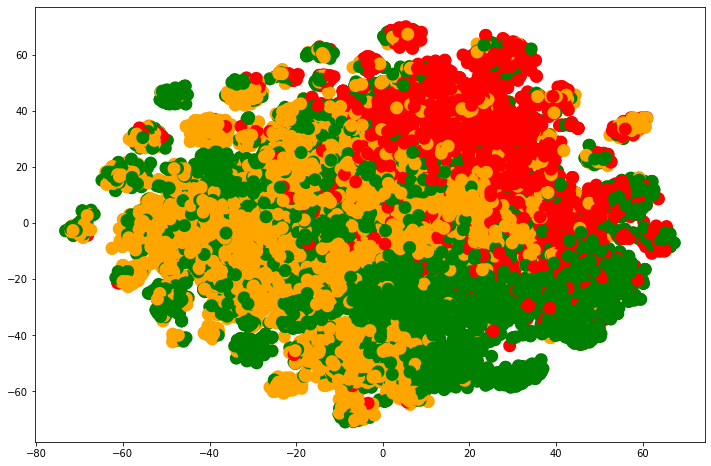

In [28]:
plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, color=colors, linewidths=7)
plt.show()